In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

RANDOM_STATE = 2

## Reading in the data and adding column headers

In [2]:
file_path = 'car_data.csv'

#read in file
df = pd.read_csv(file_path)

df.columns = ['buying_price', 'maint_cost', 'doors','person_capacity','lug_boot','safety','class']

## Next, let's take a look at the data and figure out what we need to adjust in the function to make the data usable.

In [3]:
df.head()

,buying_price,maint_cost,doors,person_capacity,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [4]:
df.describe()

,buying_price,maint_cost,doors,person_capacity,lug_boot,safety,class
count,1727,1727,1727,1727,1727,1727,1727
unique,4,4,4,3,3,3,4
top,high,high,3,4,med,med,unacc
freq,432,432,432,576,576,576,1209


Surprisingly, 1209 of the 1727 cars are rated as unnaceptable. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   buying_price     1727 non-null   object
 1   maint_cost       1727 non-null   object
 2   doors            1727 non-null   object
 3   person_capacity  1727 non-null   object
 4   lug_boot         1727 non-null   object
 5   safety           1727 non-null   object
 6   class            1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


## Converting the types from object to somthing usable

In [6]:
buy_and_maint_map = {
    'vhigh':4,
    'high':3,
    'med':2,
    'low':1
}

doors_map = {
    '2':2,
    '3':3,
    '4':4,
    '5more':5
}

capacity_map = {
    '2':2,
    '4':4,
    'more':6
}

lug_boot_map = {
    'small': 1,
    'med':2,
    'big':3
}

safety_map = {
    'low':1,
    'med':2,
    'high':3
}

class_map = {
    'unacc' : 0,
    'acc' : 1,
    'vgood': 1,
    'good' : 1
}

In [7]:
df['buying_price'] = df['buying_price'].replace(buy_and_maint_map)

df['maint_cost'] = df['maint_cost'].replace(buy_and_maint_map)

df['doors'] = df['doors'].replace(doors_map)

df['person_capacity'] = df['person_capacity'].replace(capacity_map)

df['lug_boot'] = df['lug_boot'].replace(lug_boot_map)

df['safety'] = df['safety'].replace(safety_map)

df['class'] = df['class'].replace(class_map)

C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\1265653748.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['buying_price'] = df['buying_price'].replace(buy_and_maint_map)
C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\1265653748.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['maint_cost'] = df['maint_cost'].replace(buy_and_maint_map)
C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\1265653748.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be

Could use one-hot encoding, but is not necessary in this case since we are converting all categorical to integers and our random forest function can handle categorical numerical data.

## Now let's look at the transformed data

In [8]:
df.head()

,buying_price,maint_cost,doors,person_capacity,lug_boot,safety,class
0,4,4,2,2,1,2,0
1,4,4,2,2,1,3,0
2,4,4,2,2,2,1,0
3,4,4,2,2,2,2,0
4,4,4,2,2,2,3,0


In [9]:
df.describe()

,buying_price,maint_cost,doors,person_capacity,lug_boot,safety,class
count,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000
mean,2.499131,2.499131,3.500869,4.001158,2.000579,2.000579,0.299942
std,1.118098,1.118098,1.118098,1.633229,0.816615,0.816615,0.458365
min,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
25%,1.500000,1.500000,3.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,2.000000,4.000000,4.000000,2.000000,2.000000,0.000000
75%,3.000000,3.000000,4.500000,6.000000,3.000000,3.000000,1.000000
max,4.000000,4.000000,5.000000,6.000000,3.000000,3.000000,1.000000


## Now I will make count plots for all of the predictors and the class(output var)

C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\3456643191.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["doors"], palette="Blues", ax = axes[0])
C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\3456643191.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["buying_price"], palette="Greens", ax = axes[1])
C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\3456643191.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["maint_cost"], palette="Reds", ax = axes[2])


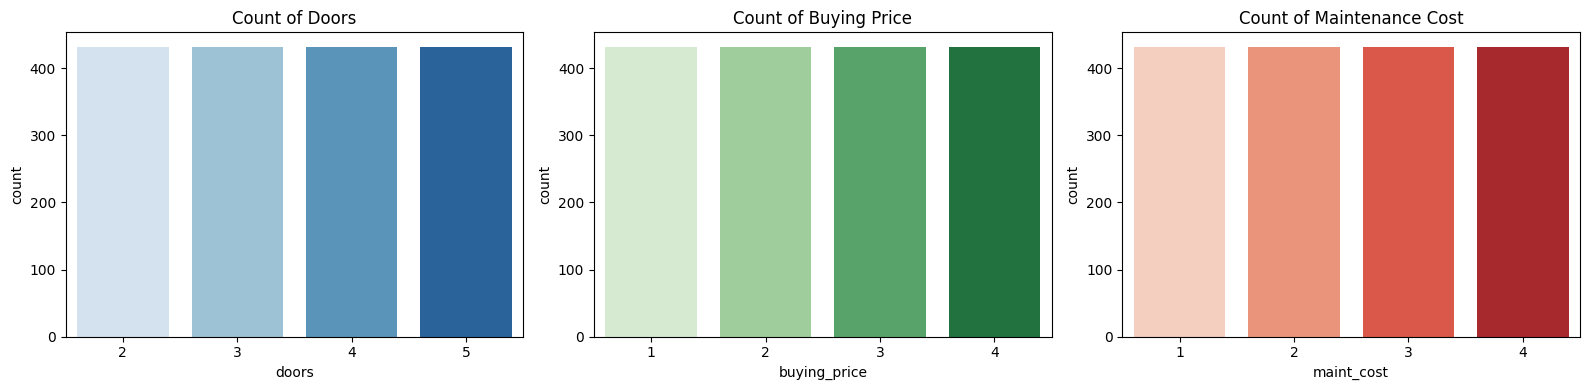

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(x = df["doors"], palette="Blues", ax = axes[0])
axes[0].set_title("Count of Doors")
sns.countplot(x = df["buying_price"], palette="Greens", ax = axes[1])
axes[1].set_title("Count of Buying Price")
sns.countplot(x = df["maint_cost"], palette="Reds", ax = axes[2])
axes[2].set_title("Count of Maintenance Cost")

plt.tight_layout()  # Avoid overlap of subplots
plt.savefig("count_plots.png", dpi=300)
plt.show()

C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\3921487808.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["lug_boot"], palette="Purples", ax = axes[0])
C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\3921487808.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["safety"], palette="Oranges", ax = axes[1])
C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\3921487808.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["person_capacity"], palette="Greys", ax = axes[2])


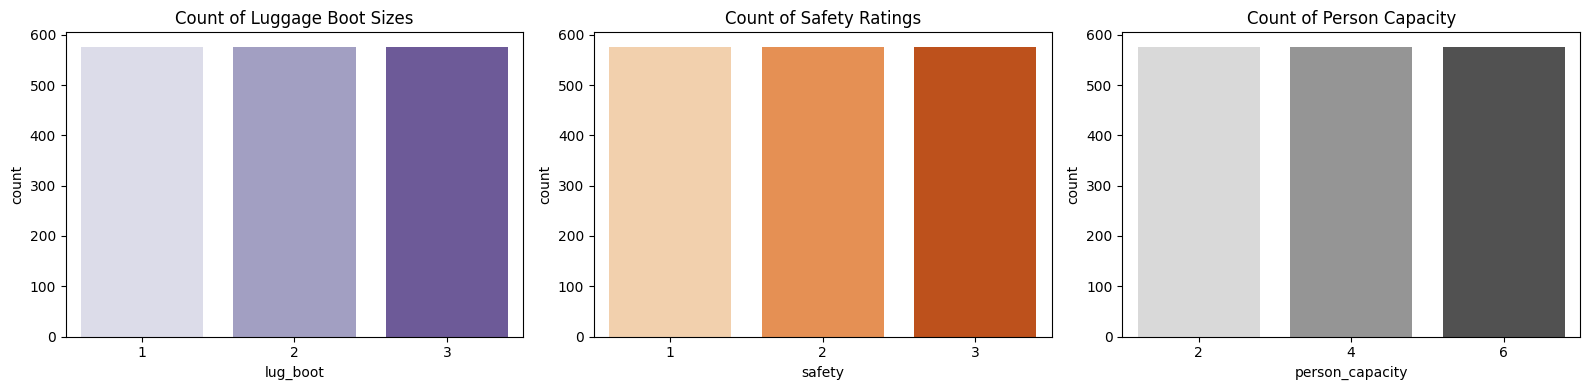

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(x = df["lug_boot"], palette="Purples", ax = axes[0])
axes[0].set_title("Count of Luggage Boot Sizes")
sns.countplot(x = df["safety"], palette="Oranges", ax = axes[1])
axes[1].set_title("Count of Safety Ratings")
sns.countplot(x = df["person_capacity"], palette="Greys", ax = axes[2])
axes[2].set_title("Count of Person Capacity")

plt.tight_layout()  # Avoid overlap of subplots
plt.savefig("count_plots2.png", dpi=300)
plt.show()

C:\Users\Spencer Steinmeyer\AppData\Local\Temp\ipykernel_10708\3179377031.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["class"], palette="Set2")


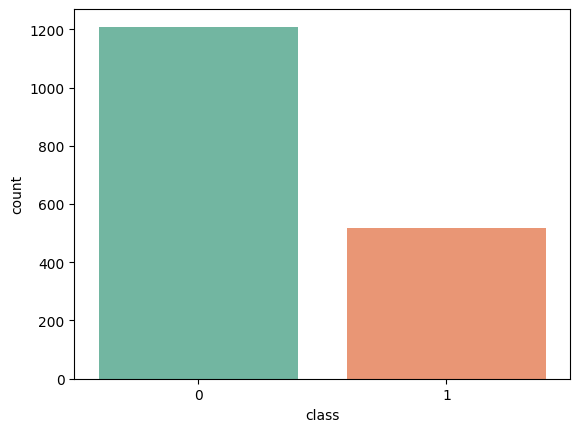

In [12]:
sns.countplot(x = df["class"], palette="Set2")
plt.savefig("count_plot_class.png", dpi=300)
plt.show()

## Let's make a correlation plot

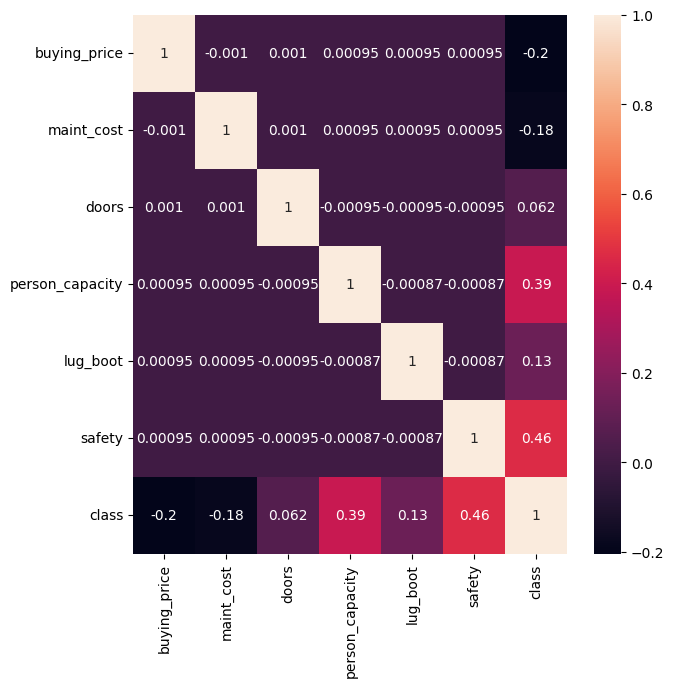

In [13]:
cm = df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True)
plt.savefig('correlation_map.png', facecolor='w', bbox_inches='tight')
plt.show()

## We can see that the highest correlated predicts with class (binary unacceptable, acceptable), are person capacity and safety level

## Now let's look at these two and their relationship with class specifically

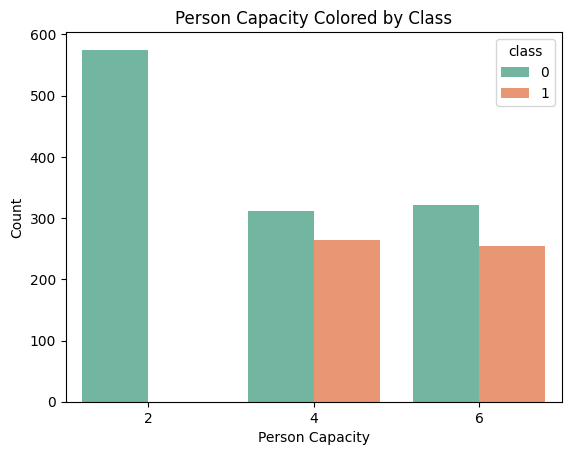

In [14]:
sns.countplot(x="person_capacity", hue="class", data=df, palette="Set2")
plt.title("Person Capacity Colored by Class")
plt.xlabel("Person Capacity")
plt.ylabel("Count")
plt.show()

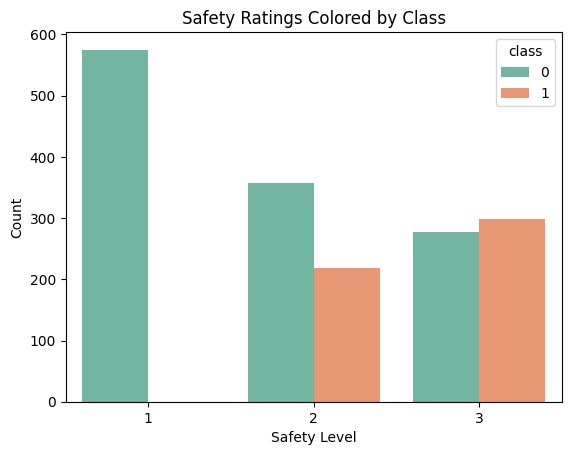

In [15]:
sns.countplot(x="safety", hue="class", data=df, palette="Set2")
plt.title("Safety Ratings Colored by Class")
plt.xlabel("Safety Level")
plt.ylabel("Count")
plt.show()

It makes sense that as safety level increases, the acceptability increases. However, I could not explain why the capacity increasing increases the acceptability of the condition of the automobile. 

Just for fun, let's also look at buying price.

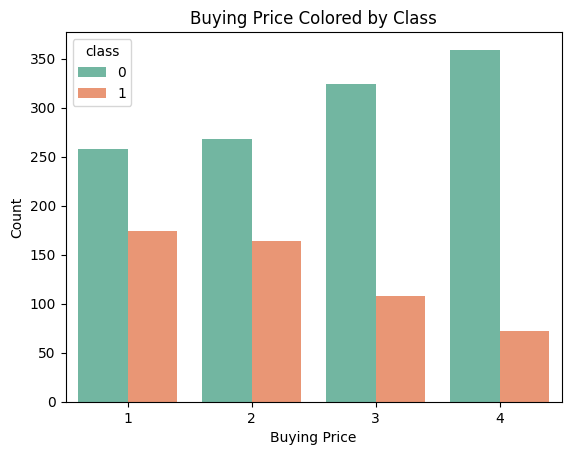

In [16]:
sns.countplot(x="buying_price", hue="class", data=df, palette="Set2")
plt.title("Buying Price Colored by Class")
plt.xlabel("Buying Price")
plt.ylabel("Count")
plt.show()

I also could not intuitively explain why the buying price has a negative relationship with condition. You would think that the higher the price, the higher the condition would be.

You would also think that person capacity and doors would have a higher correlation, which I can likewise not explain intuitively.

## Splitting data

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(df.iloc[:,0:6], df['class'], train_size = 0.8, random_state = RANDOM_STATE)

print(f'train samples: {len(xtrain)}\ntest samples: {len(xtest)}')
print(f'proportion of positive examples: {sum(ytrain)/len(ytrain):.4f}')

train samples: 1381
test samples: 346
proportion of positive examples: 0.2976


In [27]:
ytest.describe()

count    346.000000
mean       0.309249
std        0.462853
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

## Make random forests, compare accuracy with number of trees

In [19]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700,1000]  
max_depth_list = [2, 4, 8, 16, 32, 64, None]

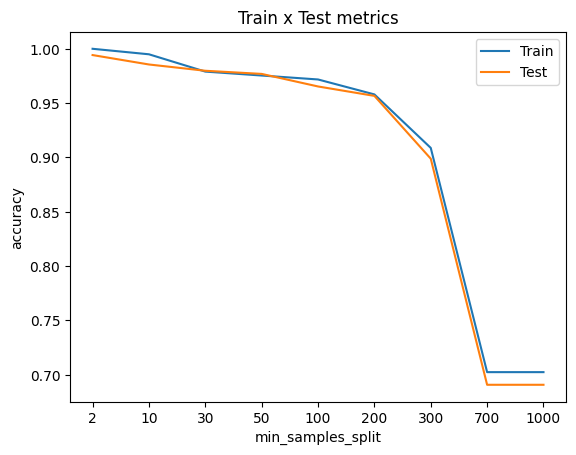

In [20]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(xtrain,ytrain) 
    predictions_train = model.predict(xtrain) ## The predicted values for the train dataset
    predictions_test = model.predict(xtest) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,ytrain)
    accuracy_test = accuracy_score(predictions_test,ytest)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

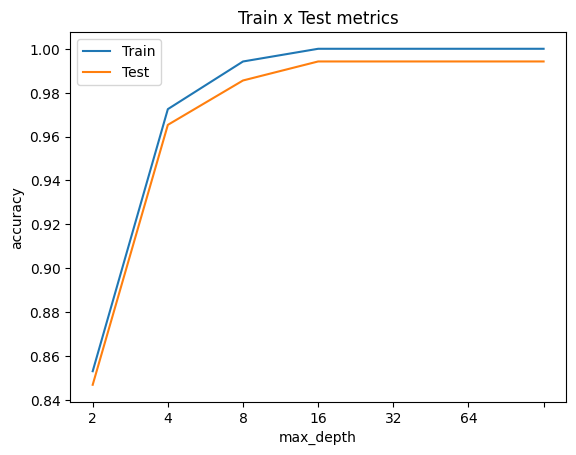

In [21]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(xtrain,ytrain) 
    predictions_train = model.predict(xtrain) ## The predicted values for the train dataset
    predictions_test = model.predict(xtest) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,ytrain)
    accuracy_test = accuracy_score(predictions_test,ytest)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

These are the sections from the notes that show us which depth and min samples to split at are the best.
From them, it seems that 30 samples to split, and a max depth of 8 are roughly the best parameters to use.

## Make random forests of varying sizes and test accuracy

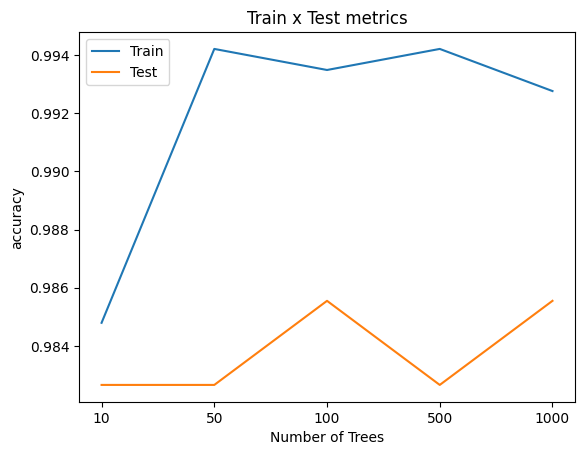

In [30]:
n_trees = [10,50,100,500,1000]
accuracy_list_train = []
accuracy_list_test = []
for n in n_trees:
    random_forest_model = RandomForestClassifier(n_estimators = n,
                                             max_depth = 8, 
                                             min_samples_split = 10).fit(xtrain,ytrain)
    predictions_train = random_forest_model.predict(xtrain) ## The predicted values for the train dataset
    predictions_test = random_forest_model.predict(xtest) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,ytrain)
    accuracy_test = accuracy_score(predictions_test,ytest)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('Number of Trees')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_trees)), labels = n_trees)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])
plt.savefig("train_vs_test_accuracy.png", dpi=300, bbox_inches='tight')  # Save as PNG file
plt.show()

## Final model

Now let's make our final model based on all of the numbers we have found to increase accuracy and reduce overfitting the best

In [23]:
finalModel = RandomForestClassifier(n_estimators = 50,
                                             max_depth = 8, 
                                             min_samples_split = 30).fit(xtrain,ytrain)

In [24]:
trainPred = finalModel.predict(xtrain)
testPred = finalModel.predict(xtest)
finalModelTrainAccuracy = accuracy_score(trainPred,ytrain)
finalModelTestAccuracy = accuracy_score(testPred,ytest)

print(f"Final Model's Training Accuracy: {finalModelTrainAccuracy}")
print(f"Final Model's Test Accuracy: {finalModelTestAccuracy}")

Final Model's Training Accuracy: 0.9811730629978277
Final Model's Test Accuracy: 0.976878612716763


In [29]:
cm = confusion_matrix(ytest, testPred)
print(cm)

[[232   7]
 [  1 106]]


In [26]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp+fp)
recall = tp/(tp+fn)
F1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision} \n Recall: {recall} \n F1 Score: {F1}")

Precision: 0.9906542056074766 
 Recall: 0.9380530973451328 
 F1 Score: 0.9636363636363636
